<a href="https://colab.research.google.com/github/giusi07/AlgorithmsMassiveDatasets/blob/main/AMD_Project_Apriori_vs_FP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Finding frequent itemsets (IMDB) <br>
Maria Giuseppina Brunelli <br>
DSE 2020/2021

### **Spark** **Setup**

In [ ]:
# install Java8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# download spark3.0.2
!wget -q http://apache.osuosl.org/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz
# unzip it
!tar xf spark-3.0.2-bin-hadoop2.7.tgz
# install findspark 
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init("spark-3.0.2-bin-hadoop2.7")# SPARK_HOME
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
import pyspark
sc = spark.sparkContext 

### **Kaggle Setup and Dataset Import**

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 72 bytes


In [ ]:
!kaggle datasets download -d ashirwadsangwan/imdb-dataset

 99% 1.43G/1.44G [00:40<00:00, 36.9MB/s]
100% 1.44G/1.44G [00:40<00:00, 37.8MB/s]


In [ ]:
!unzip imdb-dataset

Archive:  imdb-dataset.zip
  inflating: name.basics.tsv.gz      
  inflating: name.basics.tsv/name.basics.tsv  
  inflating: title.akas.tsv.gz       
  inflating: title.akas.tsv/title.akas.tsv  
  inflating: title.basics.tsv.gz     
  inflating: title.basics.tsv/title.basics.tsv  
  inflating: title.principals.tsv.gz  
  inflating: title.principals.tsv/title.principals.tsv  
  inflating: title.ratings.tsv.gz    
  inflating: title.ratings.tsv/title.ratings.tsv  


### **Read data into spark dataframes**

In [ ]:
names_df = spark.read.load("name.basics.tsv/name.basics.tsv",
                     format="csv", sep="\t", inferSchema="true", header="true")
movies_df = spark.read.load("title.basics.tsv/title.basics.tsv",
                     format="csv", sep="\t", inferSchema="true", header="true")

In [ ]:
names_df.cache()

DataFrame[nconst: string, primaryName: string, birthYear: string, deathYear: string, primaryProfession: string, knownForTitles: string]

### **Show dataframes**

In [ ]:
names_df.show(10)

+---------+---------------+---------+---------+--------------------+--------------------+
|   nconst|    primaryName|birthYear|deathYear|   primaryProfession|      knownForTitles|
+---------+---------------+---------+---------+--------------------+--------------------+
|nm0000001|   Fred Astaire|     1899|     1987|soundtrack,actor,...|tt0050419,tt00531...|
|nm0000002|  Lauren Bacall|     1924|     2014|  actress,soundtrack|tt0071877,tt01170...|
|nm0000003|Brigitte Bardot|     1934|       \N|actress,soundtrac...|tt0054452,tt00491...|
|nm0000004|   John Belushi|     1949|     1982|actor,writer,soun...|tt0077975,tt00725...|
|nm0000005| Ingmar Bergman|     1918|     2007|writer,director,a...|tt0069467,tt00509...|
|nm0000006| Ingrid Bergman|     1915|     1982|actress,soundtrac...|tt0038109,tt00368...|
|nm0000007|Humphrey Bogart|     1899|     1957|actor,soundtrack,...|tt0043265,tt00338...|
|nm0000008|  Marlon Brando|     1924|     2004|actor,soundtrack,...|tt0070849,tt00787...|
|nm0000009

In [ ]:
movies_df.show(5)

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000001|    short|          Carmencita|          Carmencita|      0|     1894|     \N|             1|   Documentary,Short|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|      0|     1892|     \N|             5|     Animation,Short|
|tt0000003|    short|      Pauvre Pierrot|      Pauvre Pierrot|      0|     1892|     \N|             4|Animation,Comedy,...|
|tt0000004|    short|         Un bon bock|         Un bon bock|      0|     1892|     \N|            \N|     Animation,Short|
|tt0000005|    short|    Blacksmith Scene|    Blacksmith Scene|      0|     1893|     \N|             1|        Comedy

# **Frequent itemsets - Actors with single role**
In this section I analyze and apply fp-growth and apriori algorithm only to records of characters that are strictly actor/actress. 
Here I show the example of "Keith Manning" who appears as actor and in other roles in the original dataframe. Then I create a new dataframe called `actors_df` that contains only actors' data 

### **Drop records of non-actors** <br>


In [ ]:
#original data
names_df.filter(names_df.primaryName == "Keith Manning").show(truncate=False)

+---------+-------------+---------+---------+--------------------------------+---------------------------------------+
|nconst   |primaryName  |birthYear|deathYear|primaryProfession               |knownForTitles                         |
+---------+-------------+---------+---------+--------------------------------+---------------------------------------+
|nm0003513|Keith Manning|\N       |\N       |camera_department,visual_effects|tt0988045,tt2802144,tt0816711,tt0434409|
|nm2622337|Keith Manning|\N       |\N       |actor,writer                    |tt2359298,tt1795011,tt1008713,tt2010966|
|nm4796978|Keith Manning|\N       |\N       |actor                           |tt2125515                              |
|nm5237004|Keith Manning|\N       |\N       |null                            |\N                                     |
|nm7471983|Keith Manning|\N       |\N       |actor                           |tt4789618                              |
|nm8870750|Keith Manning|\N       |\N       |act

In [ ]:
#remove non actors 
actors_df=names_df.filter((names_df.primaryProfession == 'actor')|(names_df.primaryProfession == 'actress'))

In [ ]:
#retain only actors information rsult 
actors_df.filter(actors_df.primaryName == "Keith Manning").show(truncate=False)


+---------+-------------+---------+---------+-----------------+--------------+
|nconst   |primaryName  |birthYear|deathYear|primaryProfession|knownForTitles|
+---------+-------------+---------+---------+-----------------+--------------+
|nm4796978|Keith Manning|\N       |\N       |actor            |tt2125515     |
|nm7471983|Keith Manning|\N       |\N       |actor            |tt4789618     |
|nm8870750|Keith Manning|\N       |\N       |actor            |tt0243652     |
+---------+-------------+---------+---------+-----------------+--------------+



actors_df contains information about 3million (circa) `actors`, while movies_df contains information about 6million (circa) `movies` 

In [ ]:
print((actors_df.count(), len(actors_df.columns)))

(2914287, 6)


In [ ]:
print((movies_df.count(), len(movies_df.columns)))

(6321302, 9)


### **Null Values** <br>
Check null values in both tables, in the columns of interest for this task: <br>
- actors_df: check columns `nconst`, `primaryName` and `knownForTitles`
- movies_df: check column `tconst`




In [ ]:
actors_df.filter(actors_df.knownForTitles.contains('\\N')).show(truncate=False)

+---------+---------------------+---------+---------+-----------------+--------------+
|nconst   |primaryName          |birthYear|deathYear|primaryProfession|knownForTitles|
+---------+---------------------+---------+---------+-----------------+--------------+
|nm0008670|Arline Abers         |\N       |\N       |actress          |\N            |
|nm0010257|Ángel Acosta         |\N       |\N       |actor            |\N            |
|nm0023948|Jay Amar             |\N       |\N       |actor            |\N            |
|nm0024384|Charles Ambrose      |\N       |\N       |actor            |\N            |
|nm0025869|Ben Ka-Seung Ting    |\N       |\N       |actor            |\N            |
|nm0038495|Anton Van Leer Ascher|1868     |1928     |actor            |\N            |
|nm0043020|Christina Avery      |\N       |\N       |actress          |\N            |
|nm0060224|Melinda Bassett      |\N       |\N       |actress          |\N            |
|nm0062077|Christine Baum       |\N       |

In [ ]:
#remove records with null values
actors_df= actors_df.filter(actors_df.knownForTitles != '\\N')
actors_df.show()

+---------+-----------------+---------+---------+-----------------+--------------------+
|   nconst|      primaryName|birthYear|deathYear|primaryProfession|      knownForTitles|
+---------+-----------------+---------+---------+-----------------+--------------------+
|nm0000084|          Li Gong|     1965|       \N|          actress|tt0473444,tt01016...|
|nm0000109|   Yasmine Bleeth|     1968|       \N|          actress|tt0131857,tt01152...|
|nm0000124|Jennifer Connelly|     1970|       \N|          actress|tt0315983,tt01800...|
|nm0000143|    Erika Eleniak|     1969|       \N|          actress|tt0083866,tt00947...|
|nm0000157|   Linda Hamilton|     1956|       \N|          actress|tt0103064,tt64508...|
|nm0000266|   Ursula Andress|     1936|       \N|          actress|tt0061452,tt00559...|
|nm0000282|   Scott Bairstow|     1970|       \N|            actor|tt0283084,tt01825...|
|nm0000283|     Brenda Bakke|     1963|       \N|          actress|tt0114608,tt01071...|
|nm0000314|  Charles 

In [ ]:
actors_df.filter(actors_df.primaryName.contains('\\N')).show(truncate=False)

+------+-----------+---------+---------+-----------------+--------------+
|nconst|primaryName|birthYear|deathYear|primaryProfession|knownForTitles|
+------+-----------+---------+---------+-----------------+--------------+
+------+-----------+---------+---------+-----------------+--------------+



In [ ]:
actors_df.filter(actors_df.nconst.contains('\\N')).show(truncate=False)

+------+-----------+---------+---------+-----------------+--------------+
|nconst|primaryName|birthYear|deathYear|primaryProfession|knownForTitles|
+------+-----------+---------+---------+-----------------+--------------+
+------+-----------+---------+---------+-----------------+--------------+



In [ ]:
movies_df.filter(movies_df.tconst.contains('\\N')).show(truncate=False)

+------+---------+------------+-------------+-------+---------+-------+--------------+------+
|tconst|titleType|primaryTitle|originalTitle|isAdult|startYear|endYear|runtimeMinutes|genres|
+------+---------+------------+-------------+-------+---------+-------+--------------+------+
+------+---------+------------+-------------+-------+---------+-------+--------------+------+



The movies dataframe does not have null values in the column of interest. 


### **Number of appearances**
This summary shows how many actors appear in 1 movie, 2 movies ecc, in order to have a clear picture that will be useful to choose the support treshold to find frequent itemsets. 

In [ ]:
from pyspark.sql.functions import size, explode, col, split
df2 = actors_df.select(split(col("knownForTitles"),",").alias("TitlesArray"))
df2 = df2.select('*',size('TitlesArray').alias('NumberMoviesAppearances'))
df2=df2.groupBy('NumberMoviesAppearances').count()
df2.withColumnRenamed('count', 'NumberOfActors').sort('NumberOfActors', ord='desc').show()

+-----------------------+--------------+
|NumberMoviesAppearances|NumberOfActors|
+-----------------------+--------------+
|                      6|             2|
|                      5|            22|
|                      3|        139020|
|                      2|        327570|
|                      4|        392877|
|                      1|       1822194|
+-----------------------+--------------+



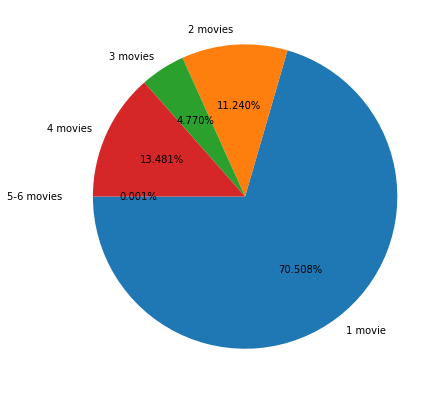

In [ ]:
import matplotlib.pyplot as plt

labels = '1 movie', '2 movies', '3 movies', '4 movies', '5-6 movies'
sizes = [2054796, 327570, 139020, 392877, 24]
explode = (0, 0, 0, 0, 0.1)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.3f%%', startangle=180)
fig1.set_size_inches(7, 7)
plt.show()

### **Drop unnecessary columns in both dataframes**

In [ ]:
actors_df_reduced= actors_df.drop('birthYear', 'deathYear', 'primaryProfession')
movies_df_reduced= movies_df.drop('titleType', 'primaryTitle', 'isAdult', 'startYear', 'endYear', 'runtimeMinutes', 'genres')

In [ ]:
#cache full dataframes for later use 
actors_df.cache()
movies_df.cache()

DataFrame[tconst: string, titleType: string, primaryTitle: string, originalTitle: string, isAdult: int, startYear: string, endYear: string, runtimeMinutes: string, genres: string]

### **Get Transactions table** <br>
Join the two tables to create a datframe containing transactions, where movies represent buckets and actors represent items. The transactions dataframe will look something like this: <br>


```
tconst|nconst 
tt0..1| nm0000001, nm0000002,..
```



In [ ]:
from pyspark.sql.functions import split, explode, col
actors_df_explode = actors_df_reduced.select(actors_df_reduced.nconst,actors_df_reduced.primaryName,explode(split(col("knownForTitles"), ",\s*")))
actors_df_explode.printSchema()
actors_df_explode.show()

root
 |-- nconst: string (nullable = true)
 |-- primaryName: string (nullable = true)
 |-- col: string (nullable = true)

+---------+-----------------+---------+
|   nconst|      primaryName|      col|
+---------+-----------------+---------+
|nm0000084|          Li Gong|tt0473444|
|nm0000084|          Li Gong|tt0101640|
|nm0000084|          Li Gong|tt0397535|
|nm0000084|          Li Gong|tt0430357|
|nm0000109|   Yasmine Bleeth|tt0131857|
|nm0000109|   Yasmine Bleeth|tt0115285|
|nm0000109|   Yasmine Bleeth|tt0337851|
|nm0000109|   Yasmine Bleeth|tt0119271|
|nm0000124|Jennifer Connelly|tt0315983|
|nm0000124|Jennifer Connelly|tt0180093|
|nm0000124|Jennifer Connelly|tt0268978|
|nm0000124|Jennifer Connelly|tt0102803|
|nm0000143|    Erika Eleniak|tt0083866|
|nm0000143|    Erika Eleniak|tt0094761|
|nm0000143|    Erika Eleniak|tt0106400|
|nm0000143|    Erika Eleniak|tt0105690|
|nm0000157|   Linda Hamilton|tt0103064|
|nm0000157|   Linda Hamilton|tt6450804|
|nm0000157|   Linda Hamilton|tt0088247

In [ ]:
from pyspark.sql import functions as F
transactions= actors_df_explode.groupby("col").agg(F.collect_list("primaryName").alias('PrimaryNames'), F.collect_list("nconst").alias('nconst'))
transactions.show()

+---------+--------------------+--------------------+
|      col|        PrimaryNames|              nconst|
+---------+--------------------+--------------------+
|tt0001170|    [Clara Williams]|         [nm0930290]|
|tt0002588|        [Léon Durac]|         [nm0243648]|
|tt0002591|[Martha Angerstei...|         [nm0029806]|
|tt0003644|     [Norman Howard]|         [nm0397525]|
|tt0003689|[Octave Luzon, Mr...|[nm0527801, nm091...|
|tt0004272|[Harry L. Rattenb...|[nm0711886, nm077...|
|tt0004336|[John Burke, Jame...|[nm1752653, nm175...|
|tt0004599|    [Lucille Bolton]|         [nm0093420]|
|tt0005209|[Max Davidson, De...|[nm0203439, nm039...|
|tt0005605|[Minnie Berlin, W...|[nm0075601, nm036...|
|tt0006204|[Blanche Bennett,...|[nm0071618, nm050...|
|tt0006207|[Francesca Cappel...|[nm0135474, nm023...|
|tt0006441|     [Martin Kinney]|         [nm0455748]|
|tt0006489|[Robert McKim, P....|[nm0571770, nm084...|
|tt0006587|     [Miriam Shelby]|         [nm0790977]|
|tt0006819|[Alice Hechy, Sig

In [ ]:
print((transactions.count(), len(transactions.columns)))

(835096, 3)


In [ ]:
from pyspark.sql.functions import size, explode, col, split
transactions=transactions.select('*',size('nconst').alias('NumberActors'))

In [ ]:
transactions.show()

+---------+--------------------+--------------------+------------+
|      col|        PrimaryNames|              nconst|NumberActors|
+---------+--------------------+--------------------+------------+
|tt0001170|    [Clara Williams]|         [nm0930290]|           1|
|tt0002588|        [Léon Durac]|         [nm0243648]|           1|
|tt0002591|[Martha Angerstei...|         [nm0029806]|           1|
|tt0003644|     [Norman Howard]|         [nm0397525]|           1|
|tt0003689|[Octave Luzon, Mr...|[nm0527801, nm091...|           2|
|tt0004272|[Harry L. Rattenb...|[nm0711886, nm077...|           4|
|tt0004336|[John Burke, Jame...|[nm1752653, nm175...|          15|
|tt0004599|    [Lucille Bolton]|         [nm0093420]|           1|
|tt0005209|[Max Davidson, De...|[nm0203439, nm039...|           2|
|tt0005605|[Minnie Berlin, W...|[nm0075601, nm036...|           2|
|tt0006204|[Blanche Bennett,...|[nm0071618, nm050...|           3|
|tt0006207|[Francesca Cappel...|[nm0135474, nm023...|         

### **FP-Growth**

In [ ]:
from pyspark.ml.fpm import FPGrowth
import time

start_time = time.time()
fpGrowth = FPGrowth(itemsCol="nconst", minSupport=0.000005)
model = fpGrowth.fit(transactions)
fp_results= model.freqItemsets
print("Executed in %.2f seconds ---" % (time.time() - start_time))

Executed in 87.39 seconds ---


In [ ]:
# Display frequent itemsets.
fp_results=fp_results.withColumn('nconst', fp_results.items[0])
fp_results=fp_results.join(actors_df, on=('nconst')).drop('birthYear', 'deathYear', 'items', 'knownForTitles')

In [ ]:
fp_results.sort(fp_results.freq.desc()).show(70)

+---------+----+--------------------+-----------------+
|   nconst|freq|         primaryName|primaryProfession|
+---------+----+--------------------+-----------------+
|nm4517234|   6|        Claydee Lupa|            actor|
|nm0472407|   6|        Dora Krsková|          actress|
|nm4079966|   5|     Jordan Bernarde|            actor|
|nm0017292|   5|         Bill Alcorn|            actor|
|nm6038165|   5|       Kuan-Ting Liu|            actor|
|nm0662565|   5|         Reed Parker|            actor|
|nm0186937|   5|        Hal Le Sueur|            actor|
|nm1708736|   5|      Sloan DeForest|          actress|
|nm5756622|   5|        Aaliyah Rose|          actress|
|nm3294984|   5| Carl Paul Ezold Jr.|            actor|
|nm3304752|   5|      Giselle Davila|          actress|
|nm5457566|   5|         Katie Reese|          actress|
|nm1948317|   5|     Chelsea Johnson|          actress|
|nm2838205|   5|Evangeline Gabrie...|          actress|
|nm5613952|   5|          Audrey Luo|          a

### Apriori

In [ ]:
import itertools
from collections import defaultdict

def getCandidateItemsets(frequents,k):
    elements=set() #set of single items
   
    #for candidate triples,quadruples,..
    if(k>2):
        for itemsets in frequents: 
            for item in itemsets: 
                elements.add(item) 
    
    #for candidate pairs
    elif(k==2):
        for item in frequents:   
            elements.add(item) 
    
    #get candidate items (pairs, triples,..) by combining single items 
    candidateItemsets=[set(itemsets) for itemsets in list(itertools.combinations(elements, k))] 
    
    return candidateItemsets

    
def getFrequentItemsets(candidateItemsets,transactions,support):
    itemsetsFrequency = defaultdict(int) 
    baskets= transactions.collect()
    
    #calculate the frequency for each candidate itemset in the baskets
    for itemset in candidateItemsets: 
        for basket in baskets: 
            if itemset.issubset(basket): 
                itemsetsFrequency[frozenset(itemset)] += 1 

    #retain only frequent itemsets
    frequentItemsets= []   
    for item in itemsetsFrequency.items(): 
        if item[1] >= support: 
            frequentItemsets.append(item) 

    return frequentItemsets

def aprioriAlgorithm(transactions, support):
  apriori_frequent=[]
  singletonMap= transactions.flatMap(lambda line: line).map(lambda item: (item , 1))
  singletonMap=singletonMap.reduceByKey(lambda a,b: (a+b))
  frequentSingletons= singletonMap.filter(lambda item: item[1] >= support)
  frequents= frequentSingletons.map(lambda item: item[0]).collect()
  apriori_frequent= frequentSingletons.collect()

  k=2
  while(len(frequents) != 0):   
        #retrive list of candidate pairs, triples, ...
        candidateItemsets=getCandidateItemsets(frequents,k) 
        #retain candidate pairs, triples... that are frequent  
        frequentItemsets=getFrequentItemsets(candidateItemsets,transactions,support)
        if (frequentItemsets): 
            apriori_frequent.append(frequentItemsets)  
        frequents=frequentItemsets 
        k=k+1 


  return apriori_frequent

In [ ]:
#get transactions from table
transactions=transactions.select('nconst').rdd.flatMap(lambda x: x)
lines = transactions.map(lambda line: ','.join(str(d) for d in line))
lines.saveAsTextFile('transactions_actors_singlerole.txt')
trans = sc.textFile('transactions_actors_singlerole.txt').map(lambda x: [str(y) for y in x.strip().split(',')])

In [ ]:
#apply Apriori
import time
start_time = time.time()
minSupport=5
aprioriResult_singlerole= aprioriAlgorithm(trans, minSupport)
print(" Executed in %.2f seconds ---" % (time.time() - start_time))

 Executed in 194.65 seconds ---


In [ ]:
#display apriori result
aprioriResult_singlerole

[('nm1948317', 5),
 ('nm1218414', 5),
 ('nm5756622', 5),
 ('nm9828634', 5),
 ('nm2838205', 5),
 ('nm0891937', 5),
 ('nm5457566', 5),
 ('nm6038165', 5),
 ('nm4517234', 6),
 ('nm0017292', 5),
 ('nm0662565', 5),
 ('nm0686428', 5),
 ('nm1708736', 5),
 ('nm5092676', 5),
 ('nm0186937', 5),
 ('nm4079966', 5),
 ('nm3304752', 5),
 ('nm0472407', 6),
 ('nm5613952', 5),
 ('nm0361727', 5),
 ('nm3294984', 5),
 ('nm8805467', 5),
 ('nm1163810', 5),
 ('nm2591423', 5)]

# **Frequent itemsets - Actors with other roles**
In this section I analyze and apply fp-growth algorithm to records of characters that are actor/actress but play also other roles. 
Here I show the example of "Keith Manning" who appears as actor and in other roles but also appears as actor and writer in the same movie. In this case I keep this record Then I create a new dataframe called `actors_wroles_df`. 

### **Drop records on non-actors**

In [ ]:
#original data
names_df.filter(names_df.primaryName == "Keith Manning").show(truncate=False)

+---------+-------------+---------+---------+--------------------------------+---------------------------------------+
|nconst   |primaryName  |birthYear|deathYear|primaryProfession               |knownForTitles                         |
+---------+-------------+---------+---------+--------------------------------+---------------------------------------+
|nm0003513|Keith Manning|\N       |\N       |camera_department,visual_effects|tt0988045,tt2802144,tt0816711,tt0434409|
|nm2622337|Keith Manning|\N       |\N       |actor,writer                    |tt2359298,tt1795011,tt1008713,tt2010966|
|nm4796978|Keith Manning|\N       |\N       |actor                           |tt2125515                              |
|nm5237004|Keith Manning|\N       |\N       |null                            |\N                                     |
|nm7471983|Keith Manning|\N       |\N       |actor                           |tt4789618                              |
|nm8870750|Keith Manning|\N       |\N       |act

In [ ]:
#keep records that have at least actor/actress 
actors_wroles_df=names_df.filter((names_df.primaryProfession.contains('actor'))|(names_df.primaryProfession.contains('actress')))

In [ ]:
#retain only actors information rsult 
actors_wroles_df.filter(actors_wroles_df.primaryName == "Keith Manning").show(truncate=False)

+---------+-------------+---------+---------+-----------------+---------------------------------------+
|nconst   |primaryName  |birthYear|deathYear|primaryProfession|knownForTitles                         |
+---------+-------------+---------+---------+-----------------+---------------------------------------+
|nm2622337|Keith Manning|\N       |\N       |actor,writer     |tt2359298,tt1795011,tt1008713,tt2010966|
|nm4796978|Keith Manning|\N       |\N       |actor            |tt2125515                              |
|nm7471983|Keith Manning|\N       |\N       |actor            |tt4789618                              |
|nm8870750|Keith Manning|\N       |\N       |actor            |tt0243652                              |
+---------+-------------+---------+---------+-----------------+---------------------------------------+



In [ ]:
print((actors_wroles_df.count(), len(actors_wroles_df.columns)))

(3624970, 6)


### **Null Values** <br>
Check null values in both tables, in the columns of interest for this task: <br>
- actors_wroles_df: check columns `nconst`, `primaryName` and `knownForTitles`
- movies_df: check column `tconst`


In [ ]:
actors_wroles_df.filter(actors_wroles_df.knownForTitles.contains('\\N')).show(truncate=False)

+---------+---------------------+---------+---------+------------------------------------------+--------------+
|nconst   |primaryName          |birthYear|deathYear|primaryProfession                         |knownForTitles|
+---------+---------------------+---------+---------+------------------------------------------+--------------+
|nm0008670|Arline Abers         |\N       |\N       |actress                                   |\N            |
|nm0010257|Ángel Acosta         |\N       |\N       |actor                                     |\N            |
|nm0023948|Jay Amar             |\N       |\N       |actor                                     |\N            |
|nm0024384|Charles Ambrose      |\N       |\N       |actor                                     |\N            |
|nm0025869|Ben Ka-Seung Ting    |\N       |\N       |actor                                     |\N            |
|nm0038495|Anton Van Leer Ascher|1868     |1928     |actor                                     |\N      

In [ ]:
#remove records with null values
actors_wroles_df= actors_wroles_df.filter(actors_wroles_df.knownForTitles != '\\N')
actors_wroles_df.show()

+---------+-------------------+---------+---------+--------------------+--------------------+
|   nconst|        primaryName|birthYear|deathYear|   primaryProfession|      knownForTitles|
+---------+-------------------+---------+---------+--------------------+--------------------+
|nm0000001|       Fred Astaire|     1899|     1987|soundtrack,actor,...|tt0050419,tt00531...|
|nm0000002|      Lauren Bacall|     1924|     2014|  actress,soundtrack|tt0071877,tt01170...|
|nm0000003|    Brigitte Bardot|     1934|       \N|actress,soundtrac...|tt0054452,tt00491...|
|nm0000004|       John Belushi|     1949|     1982|actor,writer,soun...|tt0077975,tt00725...|
|nm0000005|     Ingmar Bergman|     1918|     2007|writer,director,a...|tt0069467,tt00509...|
|nm0000006|     Ingrid Bergman|     1915|     1982|actress,soundtrac...|tt0038109,tt00368...|
|nm0000007|    Humphrey Bogart|     1899|     1957|actor,soundtrack,...|tt0043265,tt00338...|
|nm0000008|      Marlon Brando|     1924|     2004|actor,sou

In [ ]:
actors_wroles_df.filter(actors_wroles_df.primaryName.contains('\\N')).show(truncate=False)

+------+-----------+---------+---------+-----------------+--------------+
|nconst|primaryName|birthYear|deathYear|primaryProfession|knownForTitles|
+------+-----------+---------+---------+-----------------+--------------+
+------+-----------+---------+---------+-----------------+--------------+



In [ ]:
actors_wroles_df.filter(actors_wroles_df.nconst.contains('\\N')).show(truncate=False)

+------+-----------+---------+---------+-----------------+--------------+
|nconst|primaryName|birthYear|deathYear|primaryProfession|knownForTitles|
+------+-----------+---------+---------+-----------------+--------------+
+------+-----------+---------+---------+-----------------+--------------+



### **Number of appearances**
This summary shows how many actors appear in 1 movie, 2 movies ecc, in order to have a clear picture that will be useful to choose the support treshold to find frequent itemsets. 

In [ ]:
from pyspark.sql.functions import size, explode, col, split
df = actors_wroles_df.select(split(col("knownForTitles"),",").alias("TitlesArray"))
df = df.select('*',size('TitlesArray').alias('NumberMoviesAppearances'))
df=df.groupBy('NumberMoviesAppearances').count()
df.withColumnRenamed('count', 'NumberOfActors').sort('NumberOfActors', ord='desc').show()

+-----------------------+--------------+
|NumberMoviesAppearances|NumberOfActors|
+-----------------------+--------------+
|                      8|             1|
|                      7|             1|
|                      6|             3|
|                      5|            56|
|                      3|        216409|
|                      2|        443047|
|                      4|        785985|
|                      1|       1931525|
+-----------------------+--------------+



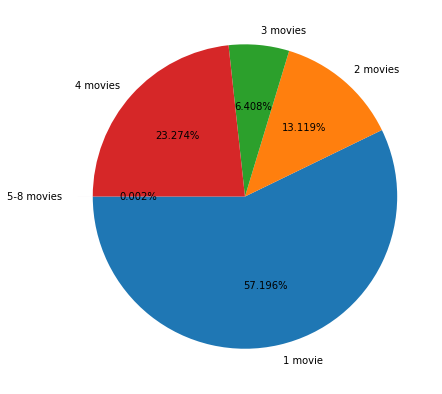

In [ ]:
import matplotlib.pyplot as plt

labels = '1 movie', '2 movies', '3 movies', '4 movies', '5-8 movies'
sizes = [1931525, 443047, 216409, 785985, 61]
explode = (0, 0, 0, 0, 0.1)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.3f%%', startangle=180)
fig1.set_size_inches(7, 7)
plt.show()

### **Drop unnecessary columns in both dataframes**

In [ ]:
actors_wroles_df_reduced= actors_wroles_df.drop('birthYear', 'deathYear', 'primaryProfession')

### **Get Transactions table** <br>
Join the two tables to create a datframe containing transactions, where movies represent buckets and actors represent items. The transactions dataframe will look something like this: <br>


```
tconst|nconst 
tt0..1| nm0000001, nm0000002,..
```


In [ ]:
from pyspark.sql.functions import split, explode, col
actors_df_wroles_explode = actors_wroles_df_reduced.select(actors_wroles_df_reduced.nconst,actors_wroles_df_reduced.primaryName,explode(split(col("knownForTitles"), ",\s*")))
actors_df_wroles_explode.printSchema()
actors_df_wroles_explode.show()

root
 |-- nconst: string (nullable = true)
 |-- primaryName: string (nullable = true)
 |-- col: string (nullable = true)

+---------+---------------+---------+
|   nconst|    primaryName|      col|
+---------+---------------+---------+
|nm0000001|   Fred Astaire|tt0050419|
|nm0000001|   Fred Astaire|tt0053137|
|nm0000001|   Fred Astaire|tt0072308|
|nm0000001|   Fred Astaire|tt0043044|
|nm0000002|  Lauren Bacall|tt0071877|
|nm0000002|  Lauren Bacall|tt0117057|
|nm0000002|  Lauren Bacall|tt0038355|
|nm0000002|  Lauren Bacall|tt0037382|
|nm0000003|Brigitte Bardot|tt0054452|
|nm0000003|Brigitte Bardot|tt0049189|
|nm0000003|Brigitte Bardot|tt0059956|
|nm0000003|Brigitte Bardot|tt0057345|
|nm0000004|   John Belushi|tt0077975|
|nm0000004|   John Belushi|tt0072562|
|nm0000004|   John Belushi|tt0080455|
|nm0000004|   John Belushi|tt0078723|
|nm0000005| Ingmar Bergman|tt0069467|
|nm0000005| Ingmar Bergman|tt0050976|
|nm0000005| Ingmar Bergman|tt0083922|
|nm0000005| Ingmar Bergman|tt0050986|
+---

In [ ]:
from pyspark.sql import functions as F
transactions_wroles= actors_df_wroles_explode.groupby("col").agg(F.collect_list("primaryName").alias('PrimaryNames'), F.collect_list("nconst").alias('nconst'))
transactions_wroles.show()

+---------+--------------------+--------------------+
|      col|        PrimaryNames|              nconst|
+---------+--------------------+--------------------+
|tt0001170|    [Clara Williams]|         [nm0930290]|
|tt0002588|        [Léon Durac]|         [nm0243648]|
|tt0002591|[Martha Angerstei...|         [nm0029806]|
|tt0003644|     [Norman Howard]|         [nm0397525]|
|tt0003689|[Mrs. E. Walton, ...|[nm0910564, nm052...|
|tt0004272|[Eva Thatcher, Je...|[nm0857118, nm036...|
|tt0004336|[Laddie the Dog, ...|[nm2919069, nm175...|
|tt0004599|[Lucille Bolton, ...|[nm0093420, nm011...|
|tt0005209|[Fay Tincher, Max...|[nm0863863, nm020...|
|tt0005605|[Minnie Berlin, E...|[nm0075601, nm032...|
|tt0006204|[Blanche Bennett,...|[nm0071618, nm050...|
|tt0006207|[Francesca Cappel...|[nm0135474, nm023...|
|tt0006441|     [Martin Kinney]|         [nm0455748]|
|tt0006489|[P. Dempsey Table...|[nm0846003, nm057...|
|tt0006587|     [Miriam Shelby]|         [nm0790977]|
|tt0006819|[Kurt Wolowsky, A

In [ ]:
print((transactions_wroles.count(), len(transactions_wroles.columns)))

(1040687, 3)


### **FP-Growth**

In [ ]:
from pyspark.ml.fpm import FPGrowth
import time

start_time = time.time()
fpGrowth2 = FPGrowth(itemsCol="nconst", minSupport=0.000004)
model2 = fpGrowth2.fit(transactions_wroles)
fp_results_wroles= model2.freqItemsets
print("Executed in %.2f seconds ---" % (time.time() - start_time))

Executed in 84.89 seconds ---


In [ ]:
fp_results_wroles=fp_results_wroles.withColumn('nconst', fp_results_wroles.items[0])
fp_results_wroles=fp_results_wroles.join(actors_wroles_df, on=('nconst')).drop('birthYear', 'deathYear', 'items', 'knownForTitles')

In [ ]:
fp_results_wroles.sort(fp_results_wroles.freq.desc()).show(70)

+----------+----+--------------------+--------------------+
|    nconst|freq|         primaryName|   primaryProfession|
+----------+----+--------------------+--------------------+
| nm1512084|   8|      Wolfgang Hofer|writer,soundtrack...|
| nm0809850|   7|  Susan Duncan Smith|soundtrack,music_...|
| nm6232022|   6|      Bill Mackenzie|actor,director,vi...|
| nm0472407|   6|        Dora Krsková|             actress|
| nm4517234|   6|        Claydee Lupa|               actor|
| nm4079966|   5|     Jordan Bernarde|               actor|
| nm9294565|   5|        Greg Zatzkis|miscellaneous,act...|
| nm6580550|   5|        Remy Cashman|actress,producer,...|
| nm5809770|   5|The Ken Darby Sin...|music_department,...|
| nm2281222|   5|         Ted Newsome|producer,director...|
| nm0017292|   5|         Bill Alcorn|               actor|
| nm2013626|   5|           CocoRosie|actress,music_dep...|
| nm9767585|   5|Freidric Macapaga...|camera_department...|
| nm4398357|   5|       Leon Fontaine|pr

### Apriori

In [ ]:
transactions_wroles=transactions_wroles.select('nconst').rdd.flatMap(lambda x: x)
lines = transactions_wroles.map(lambda line: ','.join(str(d) for d in line))
lines.saveAsTextFile('transactions_actors_wroles.txt')
trans_wroles = sc.textFile('transactions_actors_wroles.txt').map(lambda x: [str(y) for y in x.strip().split(',')])

In [ ]:
import time
start_time = time.time()
minSupport=5
aprioriResult_wroles= aprioriAlgorithm(trans_wroles,minSupport)
print(" Executed in %.2f seconds ---" % (time.time() - start_time))

 Executed in 1012.08 seconds ---


In [ ]:
aprioriResult_wroles

[('nm1948317', 5),
 ('nm1512084', 8),
 ('nm1218414', 5),
 ('nm7172326', 5),
 ('nm1835848', 5),
 ('nm6168142', 5),
 ('nm1795875', 5),
 ('nm5756622', 5),
 ('nm0809850', 7),
 ('nm1780432', 5),
 ('nm9828634', 5),
 ('nm2838205', 5),
 ('nm0891937', 5),
 ('nm8026299', 5),
 ('nm1858039', 5),
 ('nm5457566', 5),
 ('nm5809770', 5),
 ('nm6580550', 5),
 ('nm9294565', 5),
 ('nm6038165', 5),
 ('nm4517234', 6),
 ('nm0017292', 5),
 ('nm3727115', 5),
 ('nm0662565', 5),
 ('nm0686428', 5),
 ('nm1708736', 5),
 ('nm2206015', 5),
 ('nm5092676', 5),
 ('nm0186937', 5),
 ('nm6312662', 5),
 ('nm5751952', 5),
 ('nm0300543', 5),
 ('nm6083431', 5),
 ('nm5923758', 5),
 ('nm4079966', 5),
 ('nm2611302', 5),
 ('nm3304752', 5),
 ('nm0472407', 6),
 ('nm2968946', 5),
 ('nm2281222', 5),
 ('nm5230491', 5),
 ('nm9117654', 5),
 ('nm5613952', 5),
 ('nm6236508', 5),
 ('nm5973476', 5),
 ('nm0361727', 5),
 ('nm0112122', 5),
 ('nm4398357', 5),
 ('nm3294984', 5),
 ('nm4706609', 5),
 ('nm6232022', 6),
 ('nm6232025', 5),
 ('nm2013626